In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
# Chemin vers le fichier CSV
fichier_csv = 'Stage-3.csv'

# Chargement du fichier CSV dans un DataFrame
df = pd.read_csv(fichier_csv)

# Afficher les 5 premières lignes
print(df)

    Numéro  Position  Pression (Torr)  Ch. Magnétique (T) Gaz
0       33       0.0              0.0                 0.0  N2
1       34       1.4              5.0                 0.0  N2
2       35       2.0              5.0                 0.0  N2
3       36       2.6              5.0                 0.0  N2
4       37       1.4              5.0                 1.5  N2
5       38       2.0              5.0                 1.5  N2
6       39       2.6              5.0                 1.5  N2
7       41       1.4              1.0                 0.0  N2
8       42       2.0              1.0                 0.0  N2
9       43       2.6              1.0                 0.0  N2
10      44       1.4              1.0                 2.0  N2
11      45       2.0              1.0                 2.0  N2
12      46       2.6              1.0                 2.0  N2
13      47       1.4              1.0                 2.0  N2
14      48       2.0              1.0                 2.0  N2
15      

In [3]:
def load_image(file_path):
    # This two lines will let you open a .tif file as a np matrix.
    # The matrix will have a value of "intensity" in each cell, while .tif file usually contains 
    # more data associated to the camera that acquired the image, but I am no expert on this.
    # For the moment, we only care about the intensity color map 
    img = Image.open(file_path)
    img_data = np.array(img)
    return img_data

In [14]:
ligne_num = int(input())
ligne = df.iloc[ligne_num]

position = ligne['Position']
numero = int(ligne['Numéro'])

 3


In [15]:
file_path =  f"../Stage_Pic/C477{numero}.tif"
print(file_path)

# Valeurs données
ti = -26.67  # ns
tf = 73.1    # ns

# Définition des valeurs de xi, xf selon la position
if position == 1.4:
    xi, xf = 0.3, 2.6
elif position == 2:
    xi, xf = 0.9, 3.32
elif position == 2.6:
    xi, xf = 1.5, 3.9
else:
    xi, xf = None, None

# Calcul des pentes
pente_x = (xf - xi) / 1016
pente_t = (tf - ti) / 1344

# Affichage de la pente
#print(f'La pente est : {pente:.3f}')


../Stage_Pic/C47736.tif


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

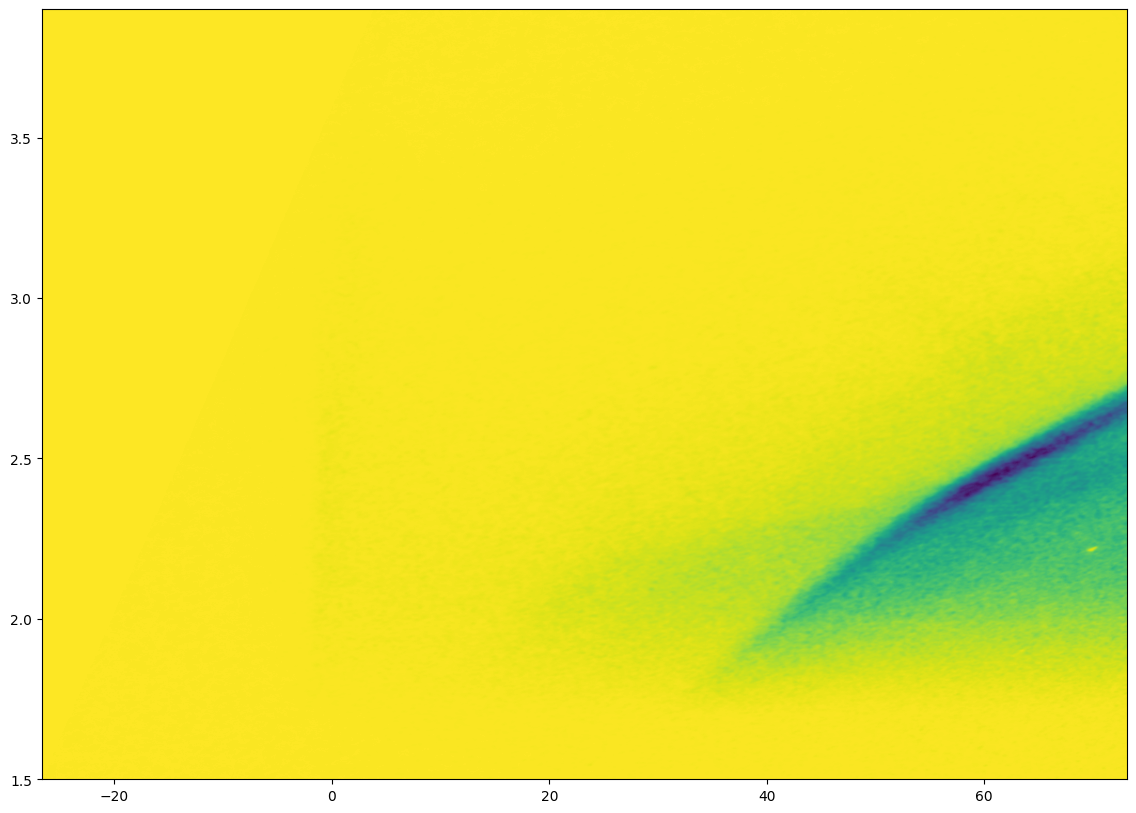

In [17]:

# Charger l'image
img_data = load_image(file_path)  # Charger l'image sous forme de matrice
img_data = np.flip(img_data, axis=0)  # Retourner l'image si nécessaire

# Tracer l'image
plt.figure(figsize=(14, 10))
plt.imshow(img_data,
           cmap='viridis_r',
           extent=[ti, tf, xi, xf],
           aspect='auto',
           vmax=np.max(img_data))  # Réglage de la luminosité maximale

t = []
x = np.arange(img_data.shape[0])  # Générer les indices des lignes de l'image

# Parcours des lignes pour trouver les pics
for j in x:
    row_data = img_data[j, :]  # Récupérer les données d'intensité de la ligne
    peaks, properties = find_peaks(row_data, height=0)  # Trouver les pics (ajuster `height` si nécessaire)
    highest_peak = peaks[np.argmax(properties['peak_heights'])]

    # Convertir l'indice du pic en coordonnées temporelles
    peak_position_real = ti + (tf - ti) * (highest_peak / img_data.shape[1])
    t.append(peak_position_real)

b_t = ti - pente_t * 0  # Ordonnée à l'origine pour t (si t = ti pour pixel = 0)
b_x = xi - pente_x * 0  # Ordonnée à l'origine pour x (si x = xi pour pixel = 0)

# Fonction pour passer des pixels en t et x
def pixels_to_t(pix1):
    return pente_t * pix1 + b_t

def pixels_to_x(pix):
    return pente_x * pix + b_x

t_values = np.array(t)  # Utiliser les positions réelles calculées
x_values = pixels_to_x(x)  # Convertir les indices en positions réelles

# Filtrer les valeurs où t_values > 0
mask = t_values > 0
t_values = t_values[mask]
x_values = np.flip(x_values[mask])

# Filtrer les points dans l'intervalle [xi, xf]
mask_interval = (x_values >= xi) & (x_values <= xf)
t_values_filtered = t_values[mask_interval]
x_values_filtered = x_values[mask_interval]

# Modèle quadratique pour ajuster les données
def quadratic_model(t_values, a, b, c):
    return a * t_values**b + c

# Ajustement avec curve_fit
params, covariance = curve_fit(quadratic_model, t_values_filtered, x_values_filtered, max)

a_fit, b_fit, c_fit = params
print(f"Paramètres ajustés : a={a_fit}, b={b_fit}, c={c_fit}")

# Générer des valeurs ajustées limitées à l'intervalle [xi, xf]
t_fit = np.linspace(np.min(t_values_filtered), np.max(t_values_filtered), 1344)
x_fit = quadratic_model(t_fit, a_fit, b_fit, c_fit)

# Filtrer les points ajustés pour l'intervalle [xi, xf]
fit_mask = (x_fit >= xi) & (x_fit <= xf)
t_fit_filtered = t_fit[fit_mask]
x_fit_filtered = x_fit[fit_mask]

# Tracer les résultats
plt.plot(t_values_filtered, x_values_filtered, 'r.', label='Points filtrés')
plt.plot(t_fit_filtered, x_fit_filtered, 'r-', label='Modèle ajusté (limité à [xi, xf])')
plt.xlabel('Temps (ns)')
plt.ylabel('Position (cm)')
plt.legend()
plt.grid()
plt.show()
